<a href="https://colab.research.google.com/github/sourcecode369/Kaggle-Kernels/blob/master/Severstal_Steel_Defect_Detection/Severstal_Steel_Defect_Detection_2_Step_Pipeline_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
files.upload()

In [0]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
!kaggle competitions download -c severstal-steel-defect-detection

  0% 0.00/6.91M [00:00<?, ?B/s]
100% 6.91M/6.91M [00:00<00:00, 115MB/s]
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
 99% 1.15G/1.16G [00:07<00:00, 171MB/s]
100% 1.16G/1.16G [00:07<00:00, 158MB/s]
 93% 120M/129M [00:00<00:00, 151MB/s]
100% 129M/129M [00:00<00:00, 144MB/s]


In [0]:
!ls

0002cc93b.jpg  3fde06814.jpg  7f8594d4b.jpg  bfd56c3d2.jpg
00031f466.jpg  3fe32ff2f.jpg  7f8d10098.jpg  bfd7696b4.jpg
000418bfc.jpg  3fe5ce55e.jpg  7f98c3635.jpg  bfd7ecfe9.jpg
000789191.jpg  3fea4633e.jpg  7f98f8f6c.jpg  bfd93cc8c.jpg
0007a71bf.jpg  3feed5ab3.jpg  7f9d758d7.jpg  bfe025097.jpg
000a4bcdd.jpg  3ff6971a7.jpg  7f9df7221.jpg  bfe1815d5.jpg
000f6bf48.jpg  3ff8946e0.jpg  7f9ea512e.jpg  bfe627357.jpg
0014fce06.jpg  3ff9adb9d.jpg  7fa8baf41.jpg  bfe812911.jpg
001982b08.jpg  3ffa37e37.jpg  7faa839e3.jpg  bff6601a3.jpg
001d1b355.jpg  400144782.jpg  7fb0c3636.jpg  bff6cdfad.jpg
001d3d093.jpg  400161088.jpg  7fc69d9fd.jpg  bff7d63af.jpg
0025bde0c.jpg  400372ad3.jpg  7fc7bab6b.jpg  bffbff9ee.jpg
002af848d.jpg  400eedff4.jpg  7fc8b1ce5.jpg  c0065dcab.jpg
002e73b3c.jpg  4014c79d3.jpg  7fc9cb824.jpg  c01fd972f.jpg
002fc4e19.jpg  4014d6f31.jpg  7fceeb19e.jpg  c0292e072.jpg
0030401a5.jpg  401614c72.jpg  7fd3d58a5.jpg  c030db0ad.jpg
003ac9d2a.jpg  4018384ba.jpg  7fd489535.jpg  c031250e1.j

In [0]:
!unzip test_images.zip 
!rm -rf test_images.zip
!unzip train_images.zip 
!rm -rf train_images.zip
!unzip train.csv.zip 
!rm -rf train.csv.zip

Archive:  test_images.zip
replace 1804f41eb.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
import os
os.environ["PYTHONHASHSEED"] = str(101)
import gc
gc.enable()
gc.collect()

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

import keras
from keras import backend as K
from keras.models import Model 
from keras.layers import Input 
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D 
from keras.layers.merge import concatenate 
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint 
from keras.optimizers import Adam, Nadam
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm 
from sklearn.model_selection import train_test_split 

In [0]:
train_df = pd.read_csv('train.csv')
print(train_df.shape)
train_df.head()

In [0]:
submission_df = pd.read_csv('sample_submission.csv')
print(submission_df.shape)
submission_df.head()

In [0]:
unique_test_images = submission_df.ImageId_ClassId.apply(lambda x: x.split("_")[0]).unique()

In [0]:
print(f"unique test images: {unique_test_images}")
print(f"unique test images shape: {unique_test_images.shape}")

In [0]:
train_df["isNan"] = pd.isna(train_df.EncodedPixels).astype(np.int)

train_df["ImageId"] = train_df.ImageId_ClassId.apply(
    lambda x: x.split('_')[0]
)
train_df.head()

In [0]:
train_nan_df = train_df.groupby("ImageId",axis=0).agg("sum") 
train_nan_df.reset_index(inplace=True)
train_nan_df.rename(columns={"isNan":"missingCount"}, inplace=True)
train_nan_df["allMissing"] = (train_nan_df["missingCount"]==4).astype(np.int)
train_nan_df.head()

In [0]:
test_nan_df = pd.DataFrame(unique_test_images, columns=['ImageId'])
print(test_nan_df.shape)
test_nan_df.head()

In [0]:
print(train_nan_df.shape)
train_nan_df.head()

In [0]:
print(train_df.shape)
train_df.head()

In [0]:
import seaborn as sns
sns.set_style("whitegrid")
sns.countplot(y="missingCount",data=train_nan_df, palette=sns.cubehelix_palette(8, start=.5, rot=-.75))

In [0]:
def load_image(code, base, resize=True):
  path = f'{base}/{code}'
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (256,256))
  return img

def validate_path(path):
  if not os.path.exists(path):
    os.makedirs(path)

In [0]:
import os
os.getcwd()

In [0]:
train_path = "../train"
validate_path(train_path)

for code in tqdm(train_nan_df.ImageId):
  img = load_image(
      code, "/content", 
  )
  path = code.replace(".jpg","")
  cv2.imwrite(f"{train_path}/{path}.png",img)

In [0]:
train_nan_df["ImageId"] = train_nan_df.ImageId.apply(lambda x: x.replace(".jpg",".png"))

In [0]:
test_path = '../test'
validate_path(test_path)

def load_test_images(code, base, resize=True):
  path = f"{base}/{code}"
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (256, 256))
  return img

for code in tqdm(test_nan_df.ImageId):
  img = load_test_images(code, "/content", resize=True)
  path = code.replace(".jpg", "")
  cv2.imwrite(f"{test_path}/{path}.png",img) 

In [0]:
test_nan_df["ImageId"] = test_nan_df.ImageId.apply(lambda x: x.replace(".jpg",".png"))

In [0]:
BATCH_SIZE = 32
def create_datagen():
  return ImageDataGenerator(
      zoom_range=0.1,
      fill_mode="constant",
      cval=0,
      rotation_range=10,
      height_shift_range = 0.1,
      width_shift_range= 0.1,
      horizontal_flip = True,
      vertical_flip = True, 
      rescale = 1/255.,
      validation_split = 0.15
  )

def create_test_gen():
  return ImageDataGenerator(rescale=1/255.).flow_from_dataframe(test_nan_df,
                                                                directory="../test/",
                                                                x_col="ImageId",
                                                                target_size=(256,256),
                                                                class_mode=None,
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False
                                                                )
def create_flow(datagen, subset):
  return datagen.flow_from_dataframe(
      train_nan_df,
      directory = "../train/",
      x_col="ImageId",
      y_col="allMissing",
      class_mode="other",
      target_size=(256,256),
      BATCH_SIZE=BATCH_SIZE,
      subset=subset
  )      

In [0]:
data_generator = create_datagen()
train_gen = create_flow(data_generator, "training")
val_generator = create_flow(data_generator, "validation")
test_gen = create_test_gen()

In [0]:
from keras.applications import ResNet50
from keras.layers import *
from keras.utils import plot_model
from keras import Sequential

In [0]:
def build_model():
  resnet = ResNet50(
      include_top = False,
      input_shape = (256,256,3),
      weights = "imagenet"
  )
  resnet.trainable = False
  model = Sequential()
  model.add(resnet)
  model.add(GlobalAveragePooling2D())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(512, activation="relu",kernel_initializer="he_uniform"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(1, activation="sigmoid"))

  model.compile(
      loss = "binary_crossentropy",
      optimizer = Nadam(),
      metrics = ["accuracy"]
  )

  model.summary()
  
  plot_model(model)
  
  return model

In [0]:
model = build_model()

In [0]:
plot_model(model)

In [0]:
from keras.callbacks import *

In [0]:
total_steps = train_nan_df.shape[0] // BATCH_SIZE

checkpoint = ModelCheckpoint(
    "resnet_model.h5",
    monitor = "val_acc",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = "auto"
)

reduce_lr = ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.3,
    patience = 5,
    verbose = 1,
    min_lr = 1e-6
)

early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 8,
    verbose = 1,
    mode = "auto",
)

history = model.fit_generator(
    train_gen, 
    steps_per_epoch = total_steps*0.85,
    validation_data = val_generator,
    validation_steps = total_steps*0.15,
    epochs = 40,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

In [0]:
print("Number of layers in the base model: ", len(model.layers))

fine_tune_at = 6

for layer in model.layers.layers[:fine_tune_at]:
  layer.trainable =  True

Number of layers in the base model:  8


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer = Nadam(),
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)              

In [0]:
fined_history = model.fit_generator(
    train_gen, 
    steps_per_epoch = total_steps*0.85,
    validation_data = val_generator,
    validation_steps = total_steps*0.15,
    epochs = 40,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/40
334/333 [==============================] - 443s 1s/step - loss: 0.6209 - acc: 0.6754 - val_loss: 1.5293 - val_acc: 0.5586

Epoch 00001: val_acc improved from 0.52520 to 0.55862, saving model to resnet_model.h5
Epoch 2/40
334/333 [==============================] - 408s 1s/step - loss: 0.5529 - acc: 0.7252 - val_loss: 0.8727 - val_acc: 0.6387

Epoch 00002: val_acc improved from 0.55862 to 0.63873, saving model to resnet_model.h5
Epoch 3/40
334/333 [==============================] - 408s 1s/step - loss: 0.5128 - acc: 0.7387 - val_loss: 1.3945 - val_acc: 0.5480

Epoch 00003: val_acc did not improve from 0.63873
Epoch 4/40
334/333 [==============================] - 413s 1s/step - loss: 0.4843 - acc: 0.7590 - val_loss: 5.6159 - val_acc: 0.5406

Epoch 00004: val_acc did not improve from 0.63873
Epoch 5/40
334/333 [==============================] - 409s 1s/step - loss: 0.4278 - acc: 0.7949 - val_loss: 1.0566 - val_acc: 0.6016

Epoch 00005: val_acc did not improve from 0.63873
Epoch 

In [0]:
def plot_learning(history):
    plt.figure(figsize=(20,12))
    plt.subplot(2,1,1)
    plt.plot(history["epochs"], history["acc"], label="Training Accuracy")
    plt.plot(history["epochs"], history["val_acc"], label="Validation Accuracy")
    plt.grid(True)
    plt.scatter(history["epochs"], history["acc"])
    plt.scatter(history["epochs"], history["val_acc"])
    sns.despine(offset=8,trim=True)
    plt.legend(loc=0)
    plt.xticks(rotation=45,fontsize=15)
    plt.yticks(rotation=45,fontsize=15)

    plt.subplot(2,1,2)
    plt.plot(history["epochs"], history["loss"], label="Training Loss")
    plt.plot(history["epochs"], history["val_loss"], label="Validation Loss")
    plt.grid(True)
    plt.scatter(history["epochs"], history["loss"])
    plt.scatter(history["epochs"], history["val_loss"])
    sns.despine(offset=8,trim=True)
    plt.legend(loc=0)
    plt.xticks(rotation=45,fontsize=15)
    plt.yticks(rotation=45,fontsize=15)

In [0]:
fined_history_df = pd.DataFrame(fined_history.history)
fined_history_df["epochs"] = fined_history.epoch
fined_history_df.tail()

,val_loss,val_acc,loss,acc,lr,epochs
35,0.152360,0.943767,0.156336,0.938968,0.000016,35
36,0.152776,0.939523,0.163198,0.937284,0.000016,36
37,0.150814,0.938462,0.151325,0.938407,0.000016,37
38,0.162149,0.935809,0.153290,0.939249,0.000016,38
39,0.140686,0.942175,0.150869,0.942713,0.000005,39


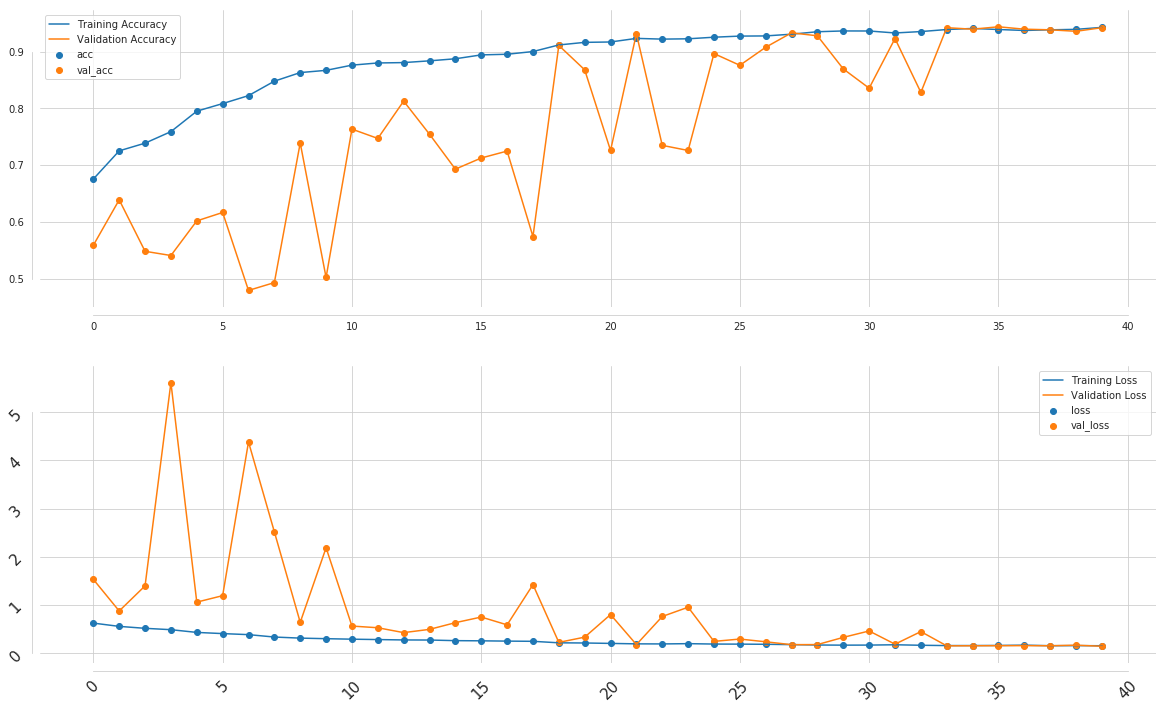

In [0]:
plot_learning(fined_history_df)

In [0]:
model.load_weights("resnet_model.h5")
y_test = model.predict_generator(
    test_gen,
    steps = len(test_gen),
    verbose = 1
)

57/57 [==============================] - 25s 445ms/step


In [0]:
test_nan_df["allMissing"] = y_test
fined_history_df.to_csv("history.csv",index=False)
train_nan_df.to_csv("train_missing_count.csv",index=False)
test_nan_df.to_csv("test_missing_count.csv",index=False)

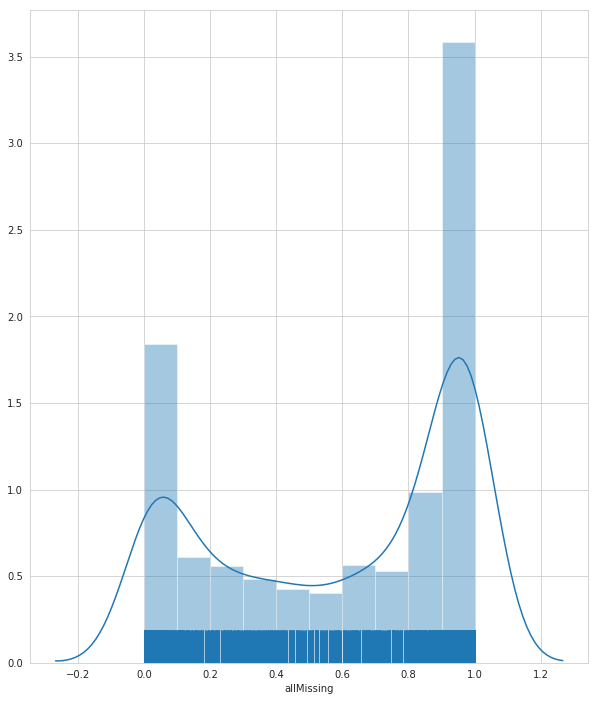

In [0]:
plt.figure(figsize=(10,12))
sns.distplot(test_nan_df["allMissing"],bins=10, rug=True, label="Distribution of Predicted labels")